<AxesSubplot: >

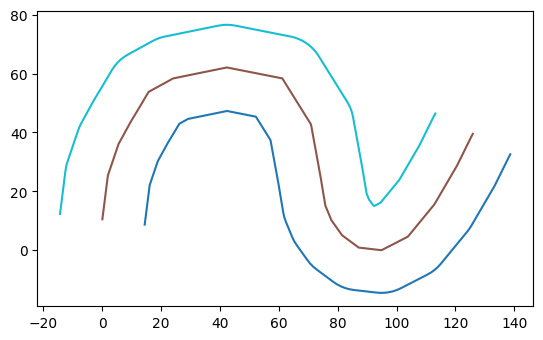

In [1]:
import pickle, os
import sys
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

import geopandas as gpd
import background_generation as backgen

root_dir ="/home/adriano/projeto_mestrado/modules"

img_dir = root_dir + '/Imagens/vessel_data/images'
#Varrendo o diretório
# filenames = []
# for filename in os.listdir(img_dir):    
#   filenames.append(filename.split('.')[0])
# filenames = filenames[:20]

imag = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 2-20X'

#Lendo o pickle e gerando o vessel_map
idx = 1
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
path = (pickle_dir + f'/{imag}_savedata1.pickle')
arquivo = pickle.load(open(path, 'rb'))
vessel_map = arquivo['vessel_model'].vessel_map
mapa_original = vessel_map.mapped_values

#Lendo o Json
#arquivo = '/content/drive/MyDrive/Mestrado em Ciência da Computação/Artificial Lines/arquivo_quatro_pontos.json'
arquivo = f'{root_dir}/Artificial_Lines/teste_31_05.json'
#arquivo = '/content/drive/MyDrive/Mestrado em Ciência da Computação/Artificial Lines/teste2_31_05.json'
#arquivo = '/content/drive/MyDrive/Mestrado em Ciência da Computação/Artificial Lines/teste.json'

medial_path = backgen.retorna_paths(arquivo)
caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(medial_path[0], 2)

linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(mapa_original,caminhos_transladados_interpolado[0])

gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
gp4.plot(cmap="tab10")


**Plotando os pontos**

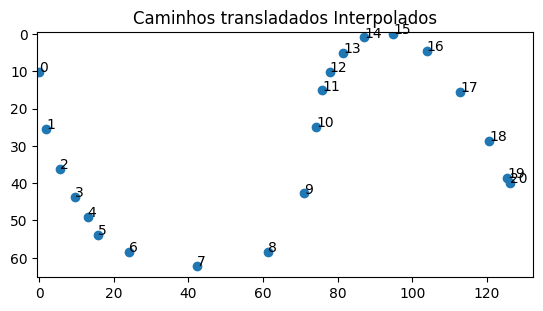

In [2]:
pontos_x = caminhos_transladados_interpolado[0][:,0]
pontos_y = caminhos_transladados_interpolado[0][:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'Caminhos transladados Interpolados' )

 ***Exibição do mapa normal***


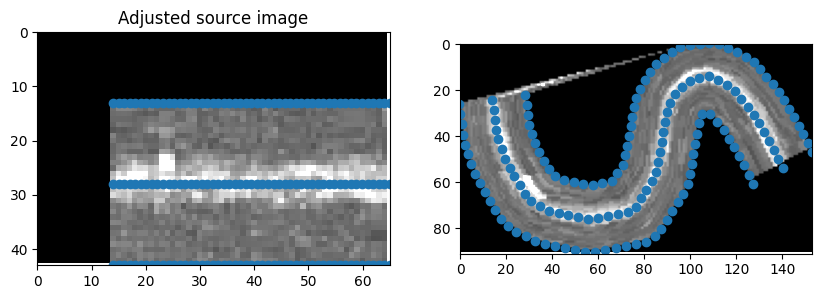

In [3]:
import numpy as np

mapa = np.array(mapa_original)

rows, cols = mapa.shape[0], mapa.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

dst_array_np = backgen.retorna_dst_array_np(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho)

img_proper, img_out, new_src, new_dst = backgen.transform_v2(src, dst_array_np, mapa)
backgen.plot(img_proper, img_out, new_src, new_dst, 60)

**Lendo o pickle e gerando o vessel_map e a imagem binária sem artefatos**

[]

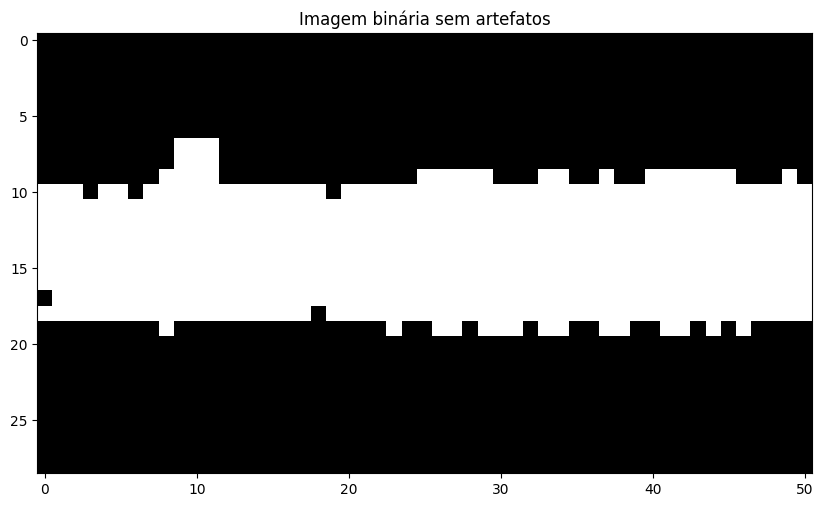

In [4]:
#import cv2
from PIL import Image
import matplotlib.pyplot as plt

img = np.array(Image.open(img_dir + f'/{imag}.tiff'))

path = (pickle_dir + f'/{imag}_savedata1.pickle')

arquivo = pickle.load(open(path, 'rb'))

vessel_map = arquivo['vessel_model'].vessel_map

mapa_original = vessel_map.mapped_values

#cv2.imwrite('mapa_original.png', mapa_original)

imagem_binaria_original = vessel_map.mapped_mask_values

imagem_binaria_sem_artefatos = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original )

plt.figure(figsize=[10, 8])
plt.title("Imagem binária sem artefatos")
plt.imshow(imagem_binaria_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

Expandir mapas

In [5]:
maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original,maior_valor_interpolado)
mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)
mask_mapa_expandido_bin = np.ones(mapa_expandido_bin.shape)

Exibindo o Mapa Aumentado

[]

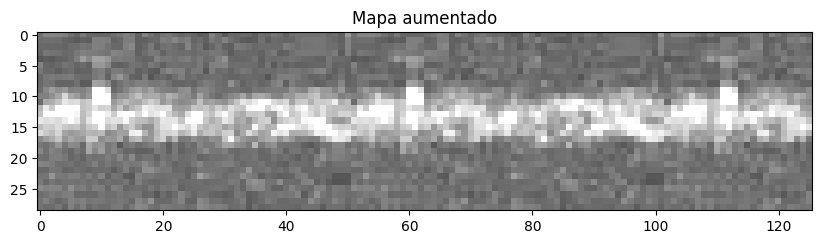

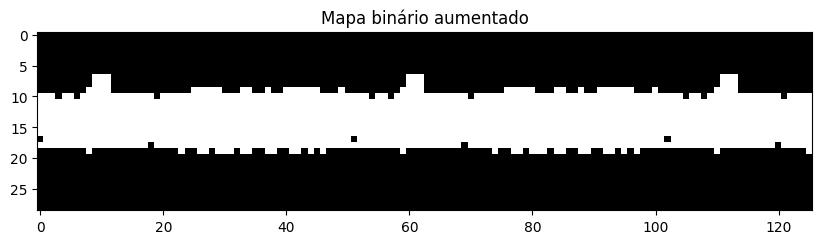

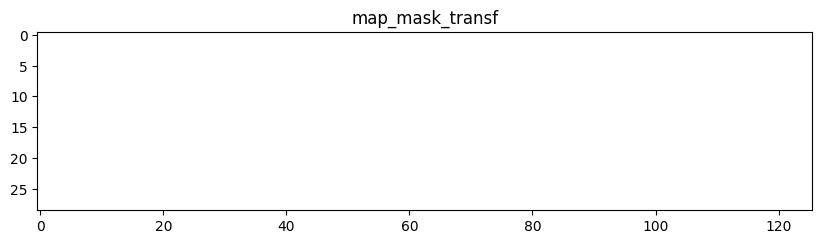

In [6]:
plt.figure(figsize=[10, 8])
plt.title("Mapa aumentado")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("Mapa binário aumentado")
plt.imshow(mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(mask_mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()

Execução do Algoritmo com o Mapa Expandido

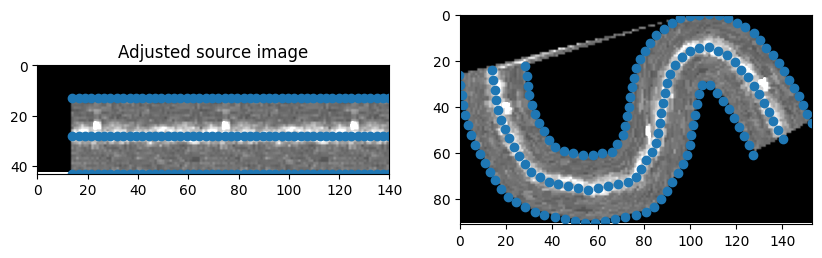

In [7]:
rows, cols = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]


img_proper, img_out, new_src, new_dst = backgen.transform_v2(src, dst_array_np, mapa_expandido_original)
backgen.plot(img_proper, img_out, new_src, new_dst,vmax=60)

Execução do Algoritmo com o Mapa Expandido - Binário

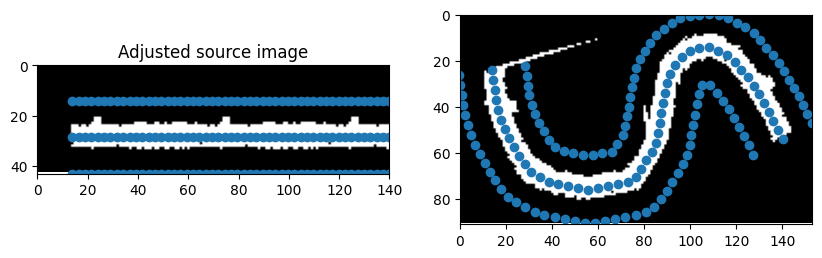

In [8]:
rows_bin, cols_bin = mapa_expandido_bin.shape[0], mapa_expandido_bin.shape[1]

src_cols_bin = np.linspace(0, cols_bin, maior_tamanho)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]


img_proper_bin, img_out_bin, new_src_bin, new_dst_bin = backgen.transform_v2(src_bin, dst_array_np, mapa_expandido_bin)
backgen.plot(img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, vmax=1)

Exibição da máscara expandida rotacionada

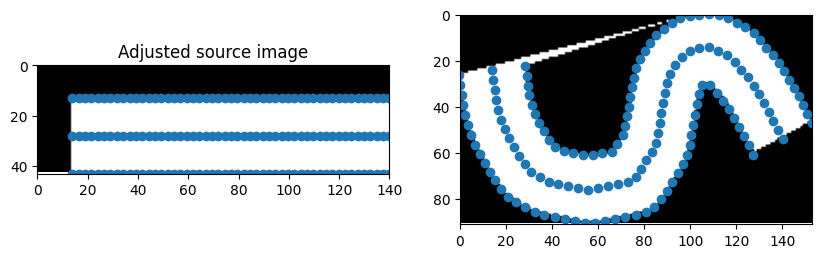

In [10]:
rows_transf_bin, cols_transf_bin = mask_mapa_expandido_bin.shape[0], mask_mapa_expandido_bin.shape[1]

src_cols_transf_bin = np.linspace(0, cols_transf_bin, maior_tamanho)
src_rows_transf_bin = np.linspace(-1, rows_transf_bin, 3)
src_cols_transf_bin, src_rows_transf_bin = np.meshgrid(src_cols_transf_bin,src_rows_transf_bin)
src_transf_bin = np.dstack([src_cols_transf_bin.flat, src_rows_transf_bin.flat])[0]


img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin = backgen.transform_v2(src_transf_bin, dst_array_np, mask_mapa_expandido_bin)
backgen.plot(img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, vmax=1)

Plotando os pontos alterados

pontos_x = new_dst[:,0]
pontos_y = new_dst[:,1]
plotar_pontos(pontos_x, pontos_y, 'New DST' )

Exibindo o mapa original e os modificados

[]

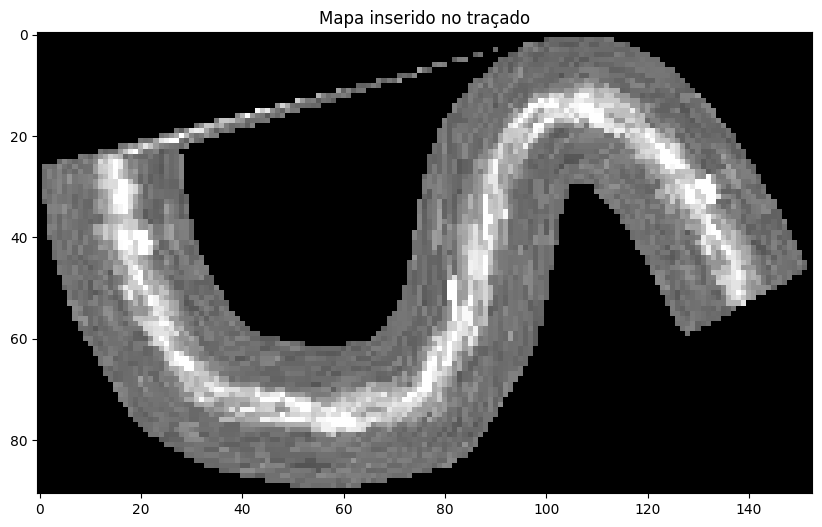

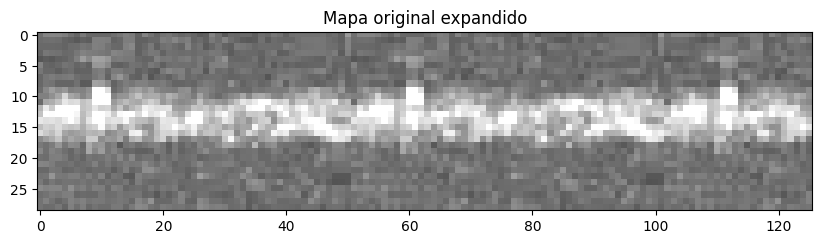

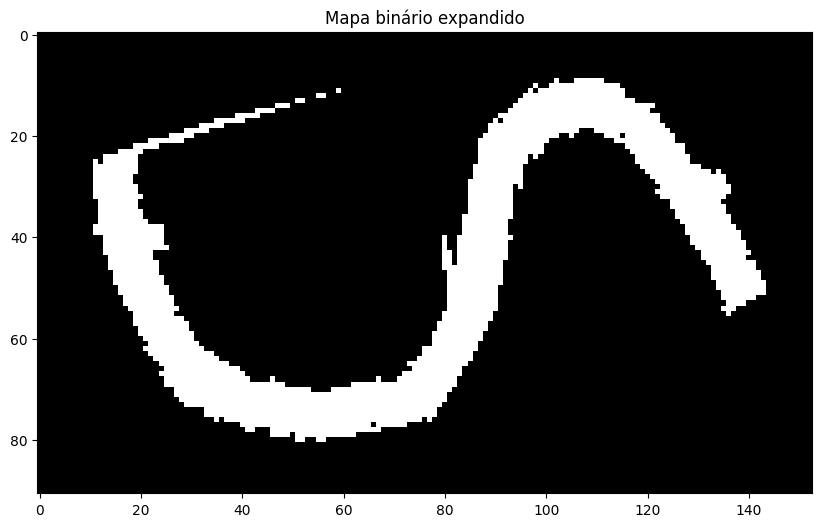

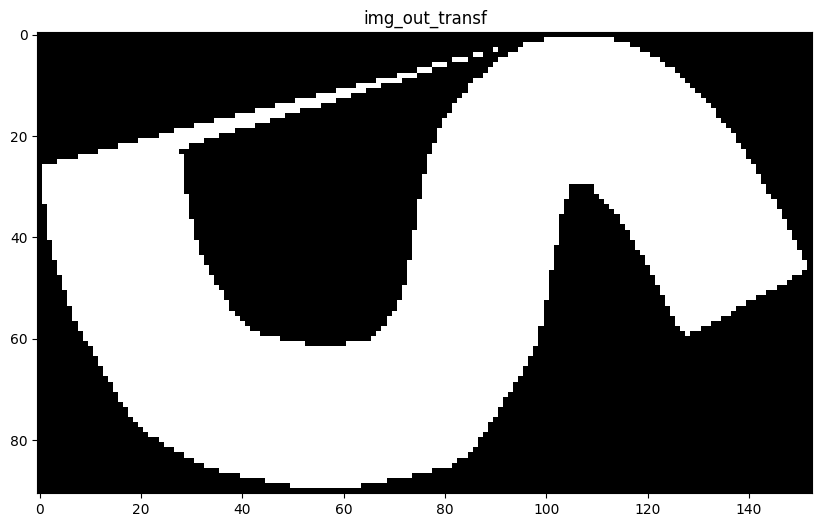

In [11]:
plt.figure(figsize=[10, 8])
plt.title("Mapa inserido no traçado")
plt.imshow(img_out, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("Mapa original expandido")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("Mapa binário expandido")
plt.imshow(img_out_bin, 'gray', vmin=0, vmax=1)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img_out_transf")
plt.imshow(img_out_transf_bin, 'gray', vmin=0, vmax=1)
plt.plot()

Inserindo o mapa em um background criado artificialmente

In [15]:
back = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{imag}.png'))

point = (500,500)
fundo_com_vaso = backgen.inserindo_vaso_no_fundo(img_out,img_out_transf_bin,point,back)

Fundo com o vaso

[]

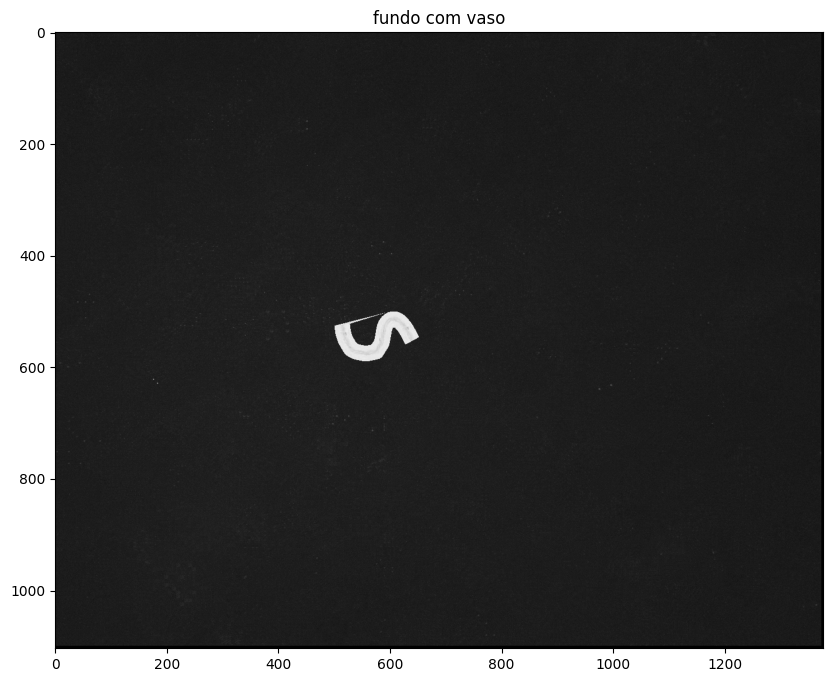

In [18]:
plt.figure(figsize=[10, 8])
plt.title("fundo com vaso")
plt.imshow(fundo_com_vaso, 'gray', vmin=0, vmax=60)
plt.plot()